In [1]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from functools import partial
from tqdm import tqdm_notebook as tqdm
from datetime import date, timedelta
import pickle
import Model_func as func

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, TimeDistributed, LeakyReLU, Conv2D, concatenate, BatchNormalization, MaxPooling2D, AveragePooling1D, Reshape
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

In [60]:
model = load_model(r'D:\Customer_Value\model\residual.h5')

In [70]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2, 120, 11)] 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 3, 120, 21)] 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 1, 120, 1)    23          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 1, 120, 1)    64          input_5[0][0]                    
____________________________________________________________________________________________

In [4]:
with open(r'D:\Customer_Value\data\evaluate\local\evaluate_large', 'rb') as fp:
    eval_test = pickle.load(fp)

In [6]:
eval_test_trade = np.array([[data[i].values.tolist() for i in range(2)] for data in eval_test])
# eval_test_asset = np.array([[data[i].values.tolist() for i in range(2, 5)] for data in eval_test])
# eval_test_demo = np.array([data[5] for data in eval_test])
# information = [data[6] for data in eval_test]

In [7]:
df = func.concat_original_df([eval_test_trade, eval_test_asset, eval_test_demo], information, r'D:\Customer_Value\data\evaluate\st_sample_all_large.csv', model)

In [8]:
f_p = func.false_positive(df)

In [9]:
f_p[['AMT_B_label', 'AMT_S_label', 'ST_ASSET_label', 'MP_ASSET_label', 'SS_ASSET_label', 'TRADE']] = f_p[['AMT_B_label', 'AMT_S_label', 'ST_ASSET_label', 'MP_ASSET_label', 'SS_ASSET_label', 'TRADE']].astype(int)
f_p = pd.get_dummies(f_p, columns=['AMT_B_label', 'AMT_S_label', 'ST_ASSET_label', 'MP_ASSET_label', 'SS_ASSET_label', 'TRADE'], prefix=['AMT_B', 'AMT_S', 'ST_ASSET', 'MP_ASSET', 'SS_ASSET', 'TRADE'])
for i in range(1, 11):
    for col in ['ST_ASSET', 'MP_ASSET', 'SS_ASSET']:
        if f'{col}_{-1 * i}' not in f_p.columns:
            f_p[f'{col}_{-1 * i}'] = 0


In [11]:
len(fp)/120

25404.0

In [10]:
df_list = [group[1] for group in f_p.groupby(f_p['sample_no'])]
train = []
val = []
test = []

if __name__ == '__main__':
    with Pool(processes=12) as pool:
        for i, x in enumerate(tqdm(pool.imap_unordered(partial(func.transfer_data, train_date='2018-11-01', val_date='2019-01-01'), df_list), total=len(df_list)), 1):
            if x[8] == 'train':
                train.append(x[:8])
            elif x[8] == 'val':
                val.append(x[:8])
            else:
                test.append(x[:8])

In [11]:
with open(r'D:\Customer_Value\data\train_residual\train_fp_v2', 'wb') as fp:
    pickle.dump(train, fp)
with open(r'D:\Customer_Value\data\train_residual\val_fp_v2', 'wb') as fp:
    pickle.dump(val, fp)
with open(r'D:\Customer_Value\data\train_residual\test_fp_v2', 'wb') as fp:
    pickle.dump(test, fp)

In [12]:
del eval_test
del eval_test_trade
del eval_test_asset
del df

In [13]:
with open(r'D:\Customer_Value\data\train_local\train_v1', 'rb') as fp:
    train_o = pickle.load(fp)
with open(r'D:\Customer_Value\data\train_local\val_v1', 'rb') as fp:
    val_o = pickle.load(fp)
with open(r'D:\Customer_Value\data\train_local\test_v1', 'rb') as fp:
    test_o = pickle.load(fp)

In [86]:
with open(r'D:\Customer_Value\data\train_residual\train_fp', 'rb') as fp:
    train_fp = pickle.load(fp)
with open(r'D:\Customer_Value\data\train_residual\val_fp', 'rb') as fp:
    val_fp = pickle.load(fp)
with open(r'D:\Customer_Value\data\train_residual\test_fp', 'rb') as fp:
    test_fp = pickle.load(fp)

KeyboardInterrupt: 

In [14]:
train_o = train_o + val_o + test_o

In [15]:
train_trade = np.array([[data[i].values.tolist() for i in range(2)] for data in train_o])
train_asset = np.array([[data[i].values.tolist() for i in range(2, 5)] for data in train_o])
train_demo = np.array([data[5] for data in train_o])
information = [data[6] for data in train_o]

In [16]:
origin_df = func.concat_original_df([train_trade, train_asset, train_demo], information, r'D:\Customer_Value\data\sample\st_sample_all.csv', model)

In [17]:
del train_trade, train_asset, train_o

In [18]:
fp_small, fn, churn, active = func.subset_df(origin_df)

In [19]:
churn = churn[churn.first_stage_1_score >= 0.5]

In [20]:
churn.head()

,first_stage_0_score,first_stage_1_score,sample_no,MTH_DATE,S_IDNO,GENDER,AGE,AMT_B,AMT_S,BIRTH_ADDRESS,...,frequency_annual,amount_annual,YEAR,sampled,ST_ASSET,MP_ASSET,SS_ASSET,ST_ASSET_label,MP_ASSET_label,SS_ASSET_label
0,0.0676,0.9324,A100106875_0,2017-04-10,A100106875,M,67.0,1894000.0,2395500.0,新北市板橋區福星里１５鄰忠孝路１０２號５樓,...,50.0,131808600.0,2017,N,0.0,756000.0,0.0,0,8,0
1,0.0676,0.9324,A100106875_0,2017-04-11,A100106875,M,67.0,0.0,0.0,新北市板橋區福星里１５鄰忠孝路１０２號５樓,...,50.0,131808600.0,2017,N,0.0,738000.0,0.0,0,8,0
2,0.0676,0.9324,A100106875_0,2017-04-12,A100106875,M,67.0,0.0,0.0,新北市板橋區福星里１５鄰忠孝路１０２號５樓,...,50.0,131808600.0,2017,N,0.0,706000.0,0.0,0,8,0
3,0.0676,0.9324,A100106875_0,2017-04-13,A100106875,M,67.0,0.0,0.0,新北市板橋區福星里１５鄰忠孝路１０２號５樓,...,50.0,130788600.0,2017,N,0.0,710000.0,0.0,0,8,0
4,0.0676,0.9324,A100106875_0,2017-04-14,A100106875,M,67.0,0.0,0.0,新北市板橋區福星里１５鄰忠孝路１０２號５樓,...,50.0,130788600.0,2017,N,0.0,710000.0,0.0,0,8,0


In [21]:
churn[['AMT_B_label', 'AMT_S_label', 'ST_ASSET_label', 'MP_ASSET_label', 'SS_ASSET_label', 'TRADE']] = churn[['AMT_B_label', 'AMT_S_label', 'ST_ASSET_label', 'MP_ASSET_label', 'SS_ASSET_label', 'TRADE']].astype(int)
churn = pd.get_dummies(churn, columns=['AMT_B_label', 'AMT_S_label', 'ST_ASSET_label', 'MP_ASSET_label', 'SS_ASSET_label', 'TRADE'], prefix=['AMT_B', 'AMT_S', 'ST_ASSET', 'MP_ASSET', 'SS_ASSET', 'TRADE'])
for i in range(1, 11):
    for col in ['ST_ASSET', 'MP_ASSET', 'SS_ASSET']:
        if f'{col}_{-1 * i}' not in churn.columns:
            churn[f'{col}_{-1 * i}'] = 0


In [22]:
df_list = [group[1] for group in churn.groupby(churn['sample_no'])]
train_churn = []
val_churn = []
test_churn = []

if __name__ == '__main__':
    with Pool(processes=12) as pool:
        for i, x in enumerate(tqdm(pool.imap_unordered(partial(func.transfer_data, train_date='2018-11-01', val_date='2019-01-01'), df_list), total=len(df_list)), 1):
            if x[8] == 'train':
                train_churn.append(x[:8])
            elif x[8] == 'val':
                val_churn.append(x[:8])
            else:
                test_churn.append(x[:8])

In [23]:
train = train + train_churn
val = val + val_churn
test = test + test_churn

In [24]:
with open(r'D:\Customer_Value\data\train_residual\train_v3', 'wb') as fp:
    pickle.dump(train, fp)
with open(r'D:\Customer_Value\data\train_residual\val_v3', 'wb') as fp:
    pickle.dump(val, fp)
with open(r'D:\Customer_Value\data\train_residual\test_v3', 'wb') as fp:
    pickle.dump(test, fp)

In [73]:
with open(r'D:\Customer_Value\data\train_residual\train_v2', 'rb') as fp:
    train = pickle.load(fp)
with open(r'D:\Customer_Value\data\train_residual\val_v2', 'rb') as fp:
    val = pickle.load(fp)
with open(r'D:\Customer_Value\data\train_residual\test_v2', 'rb') as fp:
    test = pickle.load(fp)

In [74]:
train_trade = np.array([[data[i].values.tolist() for i in range(2)] for data in train])
train_asset = np.array([[data[i].values.tolist() for i in range(2, 5)] for data in train])
train_demo = np.array([data[5] for data in train])
label_train = [data[7] for data in train]
Y_train = pd.DataFrame(label_train, columns=['label'])
Y_train = pd.get_dummies(Y_train, columns=['label'])
Y_train = Y_train.values

In [75]:
val_trade = np.array([[data[i].values.tolist() for i in range(2)] for data in val])
val_asset = np.array([[data[i].values.tolist() for i in range(2, 5)] for data in val])
val_demo = np.array([data[5] for data in val])
label_val = [data[7] for data in val]
Y_val = pd.DataFrame(label_val, columns=['label'])
Y_val = pd.get_dummies(Y_val, columns=['label'])
Y_val = Y_val.values

In [76]:
test_trade = np.array([[data[i].values.tolist() for i in range(2)] for data in test])
test_asset = np.array([[data[i].values.tolist() for i in range(2, 5)] for data in test])
test_demo = np.array([data[5] for data in test])
label_test = [data[7] for data in test]
Y_test = pd.DataFrame(label_test, columns=['label'])
Y_test = pd.get_dummies(Y_test, columns=['label'])
Y_test = Y_test.values

In [70]:
for item in train_demo:
    item = item[:4]

In [72]:
train_demo[0]

array([ 1.        , 74.        ,  0.34367546,  0.65632451,  0.08333333])

In [63]:
for i, item in enumerate(val_demo):
    item = item[:-1]
for i, item in enumerate(test_demo):
    item = item[:-1]

In [40]:
class_weight = {0: 1.,
                1: 1.5}

In [41]:
input_trade = Input(train_trade.shape[1:])
trade_model = Conv2D(filters=1, 
              strides=1, 
              padding='valid', 
              activation='relu',
              kernel_size=(1, 11),
              data_format='channels_first')(input_trade)
trade_model = Conv2D(filters=1, 
              strides=1, 
              padding='valid', 
              activation='relu',
              kernel_size=(10, 1),
              data_format='channels_first')(trade_model)
trade_model = Conv2D(filters=1, 
              strides=1, 
              padding='valid', 
              activation='relu',
              kernel_size=(10, 1),
              data_format='channels_first')(trade_model)
trade_model = Flatten()(trade_model)
input_asset = Input(train_asset.shape[1:])
asset_model = Conv2D(filters=1, 
              strides=1, 
              padding='valid', 
              activation='relu',
              kernel_size=(1, 21),
              data_format='channels_first')(input_asset)
asset_model = Conv2D(filters=1, 
              strides=1, 
              padding='valid', 
              activation='relu',
              kernel_size=(10, 1),
              data_format='channels_first')(asset_model)
asset_model = Conv2D(filters=1, 
              strides=1, 
              padding='valid', 
              activation='relu',
              kernel_size=(10, 1),
              data_format='channels_first')(asset_model)
asset_model = Flatten()(asset_model)
input_demographic = Input(train_demo.shape[1:])
combinedInput = concatenate([trade_model, asset_model, input_demographic])
full_model = Dense(128, activation='relu')(combinedInput)
full_model = Dense(32, activation='relu')(full_model)
full_model = Dense(8, activation='relu')(full_model)
full_model = Dense(2, activation='softmax')(full_model)
model = Model([input_trade, input_asset, input_demographic], full_model)
opt = optimizers.Nadam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])
model.fit([train_trade, train_asset, train_demo], Y_train, validation_data=([val_trade, val_asset, val_demo], Y_val), batch_size=8, epochs=20, verbose=2, class_weight=class_weight)

Train on 41347 samples, validate on 1956 samples
Epoch 1/20
41347/41347 - 32s - loss: 0.7410 - auc_2: 0.7153 - val_loss: 0.5476 - val_auc_2: 0.7984
Epoch 2/20
41347/41347 - 32s - loss: 0.6976 - auc_2: 0.7645 - val_loss: 0.5444 - val_auc_2: 0.8025
Epoch 3/20
41347/41347 - 32s - loss: 0.6932 - auc_2: 0.7689 - val_loss: 0.5468 - val_auc_2: 0.8115
Epoch 4/20
41347/41347 - 32s - loss: 0.6893 - auc_2: 0.7728 - val_loss: 0.5341 - val_auc_2: 0.8130
Epoch 5/20
41347/41347 - 32s - loss: 0.6867 - auc_2: 0.7748 - val_loss: 0.5312 - val_auc_2: 0.8135
Epoch 6/20
41347/41347 - 32s - loss: 0.6842 - auc_2: 0.7764 - val_loss: 0.5549 - val_auc_2: 0.7930
Epoch 7/20
41347/41347 - 32s - loss: 0.6821 - auc_2: 0.7785 - val_loss: 0.5772 - val_auc_2: 0.7650
Epoch 8/20
41347/41347 - 32s - loss: 0.6809 - auc_2: 0.7800 - val_loss: 0.5362 - val_auc_2: 0.8139
Epoch 9/20
41347/41347 - 32s - loss: 0.6788 - auc_2: 0.7815 - val_loss: 0.5631 - val_auc_2: 0.7875
Epoch 10/20
41347/41347 - 32s - loss: 0.6784 - auc_2: 0.7814

In [78]:
result = func.Evaluation([test_trade, test_asset, test_demo], label_test, threshold=0.5, model=model)
print(result[0])
print(result[1])

0.6521739130434783
              precision    recall  f1-score   support

      ACTIVE       0.81      0.49      0.61       617
       CHURN       0.57      0.85      0.68       487

    accuracy                           0.65      1104
   macro avg       0.69      0.67      0.65      1104
weighted avg       0.70      0.65      0.64      1104



In [44]:
residual = train + val + test
information = [data[6] for data in residual]
residual_trade = np.array([[data[i].values.tolist() for i in range(2)] for data in residual])
residual_asset = np.array([[data[i].values.tolist() for i in range(2, 5)] for data in residual])
residual_demo = np.array([data[5] for data in residual])

In [45]:
prediction = model.predict([residual_trade, residual_asset, residual_demo], batch_size=128)
d = pd.DataFrame(prediction, columns=['Y_0_score', 'Y_1_score'])

In [46]:
d['sample_no'] = information

In [47]:
f_p_list = [group[1] for group in f_p.groupby(f_p['sample_no'])] 
f_p = pd.concat([df.iloc[-1] for df in f_p_list], axis=1).transpose()

In [48]:
churn_list = [group[1] for group in churn.groupby(churn['sample_no'])] 
churn = pd.concat([df.iloc[-1] for df in churn_list], axis=1).transpose()

In [49]:
residual_df = pd.concat([f_p, churn], axis=0)

C:\Users\011553\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [50]:
df = pd.merge(d, residual_df, on='sample_no', how='inner')

In [51]:
df[['first_stage_0_score', 'first_stage_1_score', 'trading_days_amount_120_days', 'trading_days_total_120_days', 'frequency_annual', 'amount_annual', 'ST_ASSET']] = df[['first_stage_0_score', 'first_stage_1_score', 'trading_days_amount_120_days', 'trading_days_total_120_days', 'frequency_annual', 'amount_annual', 'ST_ASSET']].astype(np.float64)

In [52]:
def find_false(df, threshold=0.5):
    
    false_positive = df[(df.LABEL_CHURN == 'ACTIVE') & (df.Y_1_score > threshold)]
    false_negative = df[(df.LABEL_CHURN == 'CHURN') & (df.Y_0_score > threshold)]
    churn = df[(df.LABEL_CHURN == 'CHURN')]
    active = df[(df.LABEL_CHURN == 'ACTIVE')]
    
    return false_positive, false_negative, churn, active

In [53]:
fp, fn, churn, active = find_false(df)

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

C:\Users\011553\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\011553\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


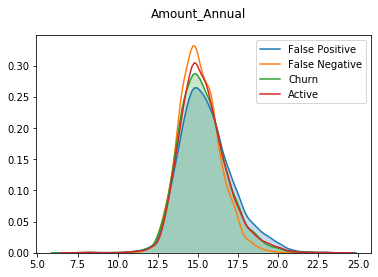

In [55]:
fig = sns.kdeplot(np.log(fp['amount_annual'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['amount_annual'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['amount_annual'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['amount_annual'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Amount_Annual", fontsize = 12)
plt.show()

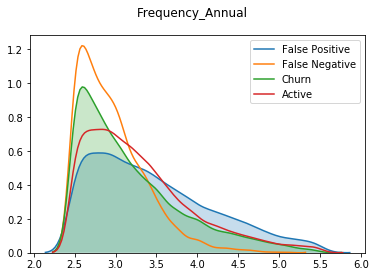

In [56]:
fig = sns.kdeplot(np.log(fp['frequency_annual'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['frequency_annual'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['frequency_annual'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['frequency_annual'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Frequency_Annual", fontsize = 12)
plt.show()

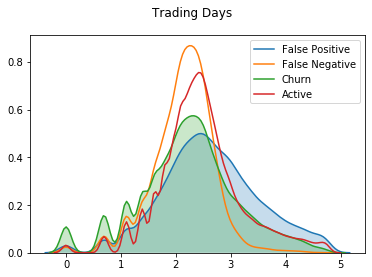

In [57]:
fig = sns.kdeplot(np.log(fp['trading_days_total_120_days'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['trading_days_total_120_days'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['trading_days_total_120_days'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['trading_days_total_120_days'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Trading Days", fontsize = 12)
plt.show()

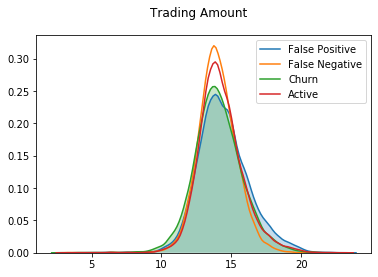

In [58]:
fig = sns.kdeplot(np.log(fp['trading_days_amount_120_days'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['trading_days_amount_120_days'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['trading_days_amount_120_days'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['trading_days_amount_120_days'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Trading Amount", fontsize = 12)
plt.show()

C:\Users\011553\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\011553\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


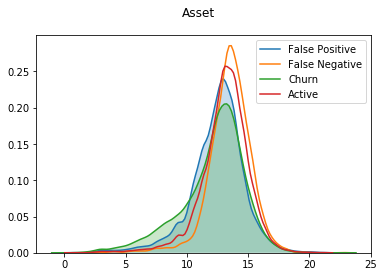

In [59]:
fig = sns.kdeplot(np.log(fp['ST_ASSET'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['ST_ASSET'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['ST_ASSET'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['ST_ASSET'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Asset", fontsize = 12)
plt.show()

In [68]:
model.save(r'D:\Customer_Value\model\residual.h5')